In [1]:
import gc
import os
import sys
import math
import random
import warnings
import pickle
from pathlib import Path
from joblib import Parallel, delayed
from statsmodels.tsa.deterministic import (CalendarFourier,
                                           CalendarSeasonality,
                                           CalendarTimeTrend,
                                           DeterministicProcess)

from tqdm import tqdm
import os
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# from pandarallel import pandarallel
# pandarallel.initialize()
warnings.simplefilter("ignore")
import ctypes as ct
from datetime import timedelta

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PowerTransformer

import lightgbm as lgbm


In [2]:
sys.path.append('../../')
import src.utils as utils

In [3]:
EXP_NUM = 1

In [4]:
DATA_DIR = Path("/home/knikaido/work/MLB-Player-Digital-Engagement-Forecasting/data/")
MAIN_DATA_DIR = DATA_DIR / 'mlb-player-digital-engagement-forecasting'
TRAIN_DIR = MAIN_DATA_DIR / 'train'
OUTPUT_DIR = Path('./output/')

In [5]:
players = pd.read_csv(MAIN_DATA_DIR / 'players.csv')

rosters = pd.read_csv(TRAIN_DIR / 'rosters_train.csv')
targets = pd.read_csv(TRAIN_DIR / 'nextDayPlayerEngagement_train.csv')
scores = pd.read_csv(TRAIN_DIR / 'playerBoxScores_train.csv')
scores = scores.groupby(['playerId', 'date']).sum().reset_index()
seasons = pd.read_csv(MAIN_DATA_DIR / 'seasons.csv')
twitters = pd.read_csv(TRAIN_DIR / 'playerTwitterFollowers_train.csv')
transactions = pd.read_csv(TRAIN_DIR / 'transactions_train.csv')
awards = pd.read_csv(TRAIN_DIR / 'awards_train.csv')


In [6]:
seasons = seasons.fillna('1970-01-01')
for c_ in seasons.columns[1:]:
    seasons[c_] = pd.to_datetime(seasons[c_].str.replace('-', '').astype(int), format="%Y%m%d")

In [7]:
seasons

,seasonId,seasonStartDate,seasonEndDate,preSeasonStartDate,preSeasonEndDate,regularSeasonStartDate,regularSeasonEndDate,lastDate1stHalf,allStarDate,firstDate2ndHalf,postSeasonStartDate,postSeasonEndDate
0,2017,2017-04-02,2017-11-01,2017-02-22,2017-04-01,2017-04-02,2017-10-01,2017-07-09,2017-07-11,2017-07-14,2017-10-03,2017-11-01
1,2018,2018-03-29,2018-10-28,2018-02-21,2018-03-27,2018-03-29,2018-10-01,2018-07-15,2018-07-17,2018-07-19,2018-10-02,2018-10-28
2,2019,2019-03-20,2019-10-30,2019-02-21,2019-03-26,2019-03-20,2019-09-29,2019-07-07,2019-07-09,2019-07-11,2019-10-01,2019-10-30
3,2020,2020-07-23,2020-10-28,2020-02-21,2020-07-22,2020-07-23,2020-09-27,2020-08-25,1970-01-01,2020-08-26,2020-09-29,2020-10-28
4,2021,2021-02-28,2021-10-31,2021-02-28,2021-03-30,2021-04-01,2021-10-03,2021-07-11,2021-07-13,2021-07-15,2021-10-04,2021-10-31


In [8]:
targets = targets.merge(scores, on=['playerId', 'date'], how='left')

In [9]:
def extract_season(date_raw, season_start_end):
    idxes = 0
    for raw in season_start_end.iloc():
        idx_ = ((date_raw >= raw.iloc[0]) & (date_raw <= raw.iloc[1])) * 1
        idxes += idx_
    return idxes

In [10]:
seasons[['seasonStartDate', 'seasonEndDate']]

,seasonStartDate,seasonEndDate
0,2017-04-02,2017-11-01
1,2018-03-29,2018-10-28
2,2019-03-20,2019-10-30
3,2020-07-23,2020-10-28
4,2021-02-28,2021-10-31


In [11]:
## only on season
on_whole_idxes = extract_season(pd.to_datetime(targets['date'], format="%Y%m%d"), seasons[['seasonStartDate', 'seasonEndDate']])
targets = targets[on_whole_idxes == 1].reset_index(drop=True)

In [12]:
targets['gameday'] = ~targets['battingOrder'].isna()*1

<AxesSubplot:xlabel='gameday', ylabel='target1'>

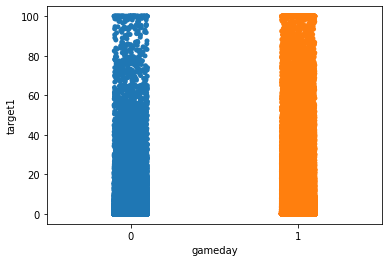

In [13]:
sns.stripplot(x="gameday", y="target1", data=targets)

(0.0, 20.0)

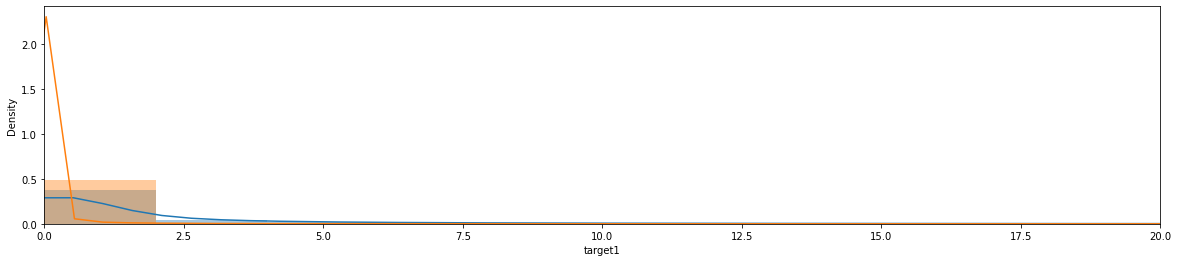

In [14]:
plt.figure(figsize=(20, 4))
sns.distplot(targets[targets['gameday']==1]['target1'])
sns.distplot(targets[targets['gameday']==0]['target1'])
plt.xlim((0, 20))

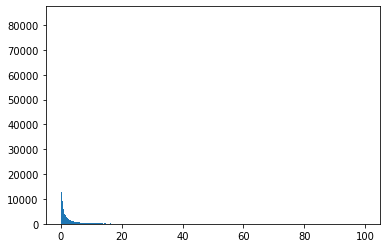

,count,mean,std,min,25%,50%,75%,max
target1,182576.0,3.319307,9.979293,0.0,0.012132,0.314775,1.99275,100.0


In [15]:
plt.hist(targets[targets['gameday'] == 1]['target1'], bins=500)
plt.show()
pd.DataFrame(targets[targets['gameday'] == 1]['target1']).describe().T

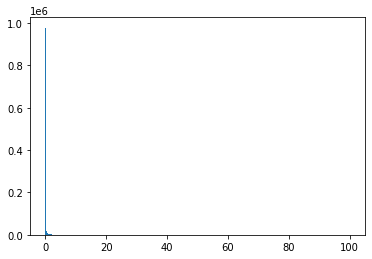

,count,mean,std,min,25%,50%,75%,max
target1,1051963.0,0.251233,2.519652,0.0,0.0,0.000338,0.004334,100.0


In [16]:
plt.hist(targets[targets['gameday'] == 0]['target1'], bins=500)
plt.show()
pd.DataFrame(targets[targets['gameday'] == 0]['target1']).describe().T

In [17]:
targets[(targets['gameday'] == 0) & (targets['target1'] == 100)]

,engagementMetricsDate,playerId,target1,target2,target3,target4,index_x,date,home,gamePk,...,sacFliesPitching,saves,holds,blownSaves,assists,putOuts,errors,chances,index_y,gameday
3110,2018-03-31,400085,100.0,58.754188,56.835467,100.000000,88,20180330,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
36085,2018-04-16,592450,100.0,88.558306,20.232832,14.533902,104,20180415,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
41425,2018-04-19,518792,100.0,19.722528,20.450886,8.057999,107,20180418,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
52292,2018-04-24,519144,100.0,30.519114,2.719682,9.656489,112,20180423,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
66327,2018-05-01,645277,100.0,42.446391,7.956336,19.143196,119,20180430,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1166649,2021-03-30,641355,100.0,25.102881,0.373461,10.266812,1183,20210329,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1170406,2021-03-31,605141,100.0,25.050011,1.320544,13.088908,1184,20210330,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1170995,2021-04-01,408234,100.0,87.248645,50.133591,63.590085,1185,20210331,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1175634,2021-04-03,596142,100.0,10.607987,1.496474,8.109946,1187,20210402,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [18]:
targets[(targets['playerId'] == 660271)]

,engagementMetricsDate,playerId,target1,target2,target3,target4,index_x,date,home,gamePk,...,sacFliesPitching,saves,holds,blownSaves,assists,putOuts,errors,chances,index_y,gameday
67,2018-03-30,660271,28.586192,39.194208,19.938088,8.715846,87,20180329,0.0,529412.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87.0,1
2462,2018-03-31,660271,0.829422,55.112297,4.324438,10.485145,88,20180330,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
5552,2018-04-01,660271,71.858709,100.000000,100.000000,84.963894,89,20180331,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
6235,2018-04-02,660271,31.406701,81.325236,100.000000,75.396975,90,20180401,0.0,529450.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,90.0,1
8358,2018-04-03,660271,68.388886,100.000000,66.237838,100.000000,91,20180402,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1225038,2021-04-27,660271,69.062271,100.000000,100.000000,100.000000,1211,20210426,0.0,634377.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1211.0,1
1227273,2021-04-28,660271,4.503799,37.984496,10.510792,52.950157,1212,20210427,0.0,634359.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1212.0,1
1228409,2021-04-29,660271,17.319229,40.329459,64.044348,38.428984,1213,20210428,0.0,634350.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1213.0,1
1231130,2021-04-30,660271,6.844256,36.335051,18.525477,46.073708,1214,20210429,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [19]:
players[players['playerId'] == 543424]

,playerId,playerName,DOB,mlbDebutDate,birthCity,birthStateProvince,birthCountry,heightInches,weight,primaryPositionCode,primaryPositionName,playerForTestSetAndFuturePreds
1242,543424,John Lamb,1990-07-10,2015-08-14,La Palma,CA,USA,76,205,1,Pitcher,False


In [20]:
twitters[twitters['playerId'] == 543424]

,date,playerId,playerName,accountName,twitterHandle,numberOfFollowers,index


In [21]:
awards[awards['playerId'] == 543424]

,awardId,awardName,awardDate,awardSeason,playerId,playerName,awardPlayerTeamId,index,date


In [22]:
transactions[transactions['playerId'] == 543424]

,transactionId,playerId,playerName,date,fromTeamId,fromTeamName,toTeamId,toTeamName,effectiveDate,resolutionDate,typeCode,typeDesc,description,index
317,341184,543424.0,John Lamb,20180122,NaN,NaN,108,Los Angeles Angels,2018-01-22,2018-01-22,SFA,Signed as Free Agent,Los Angeles Angels signed free agent LHP John ...,21
6701,361005,543424.0,John Lamb,20180616,561.0,Salt Lake Bees,108,Los Angeles Angels,2018-06-16,NaN,SE,Selected,Los Angeles Angels selected the contract of LH...,166
7479,364799,543424.0,John Lamb,20180627,NaN,NaN,108,Los Angeles Angels,2018-06-27,2018-06-27,SC,Status Change,Los Angeles Angels placed LHP John Lamb on the...,177
9317,371494,543424.0,John Lamb,20180727,NaN,NaN,108,Los Angeles Angels,2018-07-27,2018-07-27,SC,Status Change,Los Angeles Angels transferred LHP John Lamb f...,207
11860,381863,543424.0,John Lamb,20181101,NaN,NaN,108,Los Angeles Angels,2018-11-01,2018-11-01,SC,Status Change,LHP John Lamb roster status changed by Los Ang...,304
11903,381865,543424.0,John Lamb,20181101,108.0,Los Angeles Angels,561,Salt Lake Bees,2018-11-01,NaN,OUT,Outrighted,Los Angeles Angels sent LHP John Lamb outright...,304


In [29]:
targets = pd.read_csv(TRAIN_DIR / 'nextDayPlayerEngagement_train.csv')
targets = pd.merge(targets, players, how='left', on='playerId')

In [30]:
player_ids = targets[targets['playerForTestSetAndFuturePreds']!=False]['playerId'].unique()

id=660271, name=Shohei Ohtani


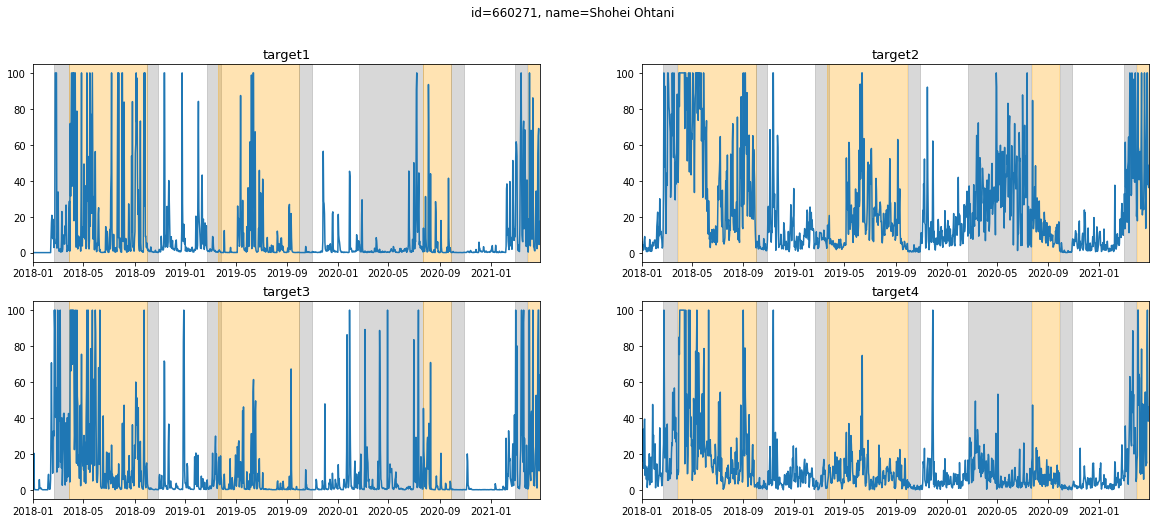

In [40]:

# id_ = player_ids[np.random.randint(len(player_ids))]
id_ = player_ids[10]
id_ = 660271
target_oneplayer = targets[(targets['playerId'] == id_)]
name = players[players['playerId'] == id_]['playerName']
print(f'id={id_}, name={name.values[0]}')

fig, ax = plt.subplots(2, 2, figsize=(20, 8))
fig.suptitle(f'id={id_}, name={name.values[0]}')
for i in range(len(seasons)):
    ax[0][0].axvspan(seasons['preSeasonStartDate'][i], seasons['preSeasonEndDate'][i], color="gray", alpha=0.3)
for i in range(len(seasons)):
    ax[0][0].axvspan(seasons['regularSeasonStartDate'][i], seasons['regularSeasonEndDate'][i], color="orange", alpha=0.3)
for i in range(len(seasons)):
    ax[0][0].axvspan(seasons['postSeasonStartDate'][i], seasons['postSeasonEndDate'][i], color="gray", alpha=0.3)
dates = pd.to_datetime(target_oneplayer['date'], format="%Y%m%d").values
ax[0][0].plot(dates, target_oneplayer['target1'].values)
ax[0][0].set_xlim(np.min(dates), np.max(dates))
ax[0][0].set_title('target1', fontsize=13)
ax[0][0].set_aspect(aspect='auto')

for i in range(len(seasons)):
    ax[0][1].axvspan(seasons['preSeasonStartDate'][i], seasons['preSeasonEndDate'][i], color="gray", alpha=0.3)
for i in range(len(seasons)):
    ax[0][1].axvspan(seasons['regularSeasonStartDate'][i], seasons['regularSeasonEndDate'][i], color="orange", alpha=0.3)
for i in range(len(seasons)):
    ax[0][1].axvspan(seasons['postSeasonStartDate'][i], seasons['postSeasonEndDate'][i], color="gray", alpha=0.3)
dates = pd.to_datetime(target_oneplayer['date'], format="%Y%m%d").values
ax[0][1].plot(dates, target_oneplayer['target2'].values)
ax[0][1].set_xlim(np.min(dates), np.max(dates))
ax[0][1].set_title('target2', fontsize=13)
ax[0][1].set_aspect(aspect='auto')

for i in range(len(seasons)):
    ax[1][0].axvspan(seasons['preSeasonStartDate'][i], seasons['preSeasonEndDate'][i], color="gray", alpha=0.3)
for i in range(len(seasons)):
    ax[1][0].axvspan(seasons['regularSeasonStartDate'][i], seasons['regularSeasonEndDate'][i], color="orange", alpha=0.3)
for i in range(len(seasons)):
    ax[1][0].axvspan(seasons['postSeasonStartDate'][i], seasons['postSeasonEndDate'][i], color="gray", alpha=0.3)
dates = pd.to_datetime(target_oneplayer['date'], format="%Y%m%d").values
ax[1][0].plot(dates, target_oneplayer['target3'].values)
ax[1][0].set_xlim(np.min(dates), np.max(dates))
ax[1][0].set_title('target3', fontsize=13)
ax[1][0].set_aspect(aspect='auto')

for i in range(len(seasons)):
    ax[1][1].axvspan(seasons['preSeasonStartDate'][i], seasons['preSeasonEndDate'][i], color="gray", alpha=0.3)
for i in range(len(seasons)):
    ax[1][1].axvspan(seasons['regularSeasonStartDate'][i], seasons['regularSeasonEndDate'][i], color="orange", alpha=0.3)
for i in range(len(seasons)):
    ax[1][1].axvspan(seasons['postSeasonStartDate'][i], seasons['postSeasonEndDate'][i], color="gray", alpha=0.3)
dates = pd.to_datetime(target_oneplayer['date'], format="%Y%m%d").values
ax[1][1].plot(dates, target_oneplayer['target4'].values)
ax[1][1].set_xlim(np.min(dates), np.max(dates))
ax[1][1].set_title('target4', fontsize=13)
ax[1][1].set_aspect(aspect='auto')

# plt.show()

## target1, 3は0の区間が多い気がする

In [ ]:
targets = pd.merge(targets, scores, how='left', on=['playerId', 'date']) 
date_ = pd.to_datetime(targets['date'], format="%Y%m%d")
targets['month'] = date_.dt.month

In [ ]:
targets['gameday'] = targets['battingOrder'].isna()*1

In [ ]:
targets[targets['gameday']==0]

In [ ]:
plt.figure(figsize=(15, 8))
sns.violinplot(x="month", y="target1", data=targets)

In [ ]:
sns.violinplot(x="gameday", y="target2", data=targets)

In [ ]:
sns.violinplot(x="gameday", y="target3", data=targets)

In [ ]:
sns.violinplot(x="gameday", y="target4", data=targets)

In [ ]:
plt.hist(targets['target1'], bins=500)
plt.show()
pd.DataFrame(targets['target1']).describe().T

In [ ]:
plt.figure(figsize=(15, 4))
plt.plot(pd.to_datetime(targets['date'], format="%Y%m%d").values[::100], targets['target2'].values[::100])

In [ ]:
# targets.sort_values('target1', ascending=False)

In [ ]:
plt.hist(targets['target2'], bins=500)
plt.show()
pd.DataFrame(targets['target2']).describe().T

In [ ]:
plt.figure(figsize=(15, 4))
plt.plot(pd.to_datetime(targets['date'], format="%Y%m%d").values[::100], targets['target3'].values[::100])

In [ ]:
plt.hist(targets['target3'], bins=500)
plt.show()
pd.DataFrame(targets['target3']).describe().T

In [2]:
plt.figure(figsize=(15, 4))
plt.plot(pd.to_datetime(targets['date'], format="%Y%m%d").values[::100], targets['target4'].values[::100])

NameError: name 'plt' is not defined

In [ ]:
plt.hist(targets['target4'], bins=500)
plt.show()
pd.DataFrame(targets['target4']).describe().T

In [ ]:
# pt = PowerTransformer()

In [ ]:
# target4_norm = pt.fit_transform(targets['target4'].values.reshape(-1,1)).reshape(-1)

In [ ]:
# plt.hist(target4_norm, bins=500)
# plt.show()
# pd.DataFrame(target4_norm).describe().T